# Invariant MNIST Classifier

## Intro
* **Date**: 1/14/2021
* **What**: It's finally here, bois.  After months of classifier silence, I've finally figured out how to find and group topologically similar terms.  So yeah this architecture is MWTA, Var XI, WTA.  So three layers.  I'll be doing simple WTA classification as well.
* **Why**: Well, it's time to see whether my invariant layer is actually useful when it comes to classification.  I'd certainly hope so, but you never know.
* **Hopes**: My hope beyond all hopes is that this gets a better classification accuracy than the stupid Krotov Hopfield wta network. 
* **Limitations**: It probably won't, given the universe's propensity to break things I build, especially on the first try.  

## Code

In [1]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from tensorflow.keras.datasets import mnist
from tqdm import tqdm

m_len = 60_000
m_area = 28 * 28

(x_tr, y_tr), (x_te, y_te) = mnist.load_data()

x_tr = x_tr / 255.0
x_te = x_te / 255.0

In [2]:
flat_tr = x_tr.reshape(-1, m_area)
flat_te = x_te.reshape(-1, m_area)

gp_ftr = cp.asarray(flat_tr)
gp_fte = cp.asarray(flat_te)

In [3]:
t_sl = 30 # Tapestry side length
m_sl = 28 # Side length of each images

tapestry = np.zeros((t_sl * m_sl, t_sl * m_sl))

x_i = 0

for x in range(t_sl):
    for y in range(t_sl):

        tapestry[y * m_sl : (y + 1) * m_sl, x * m_sl : (x + 1) * m_sl] = x_tr[x_i]
        x_i += 1
        
tapestry[(t_sl - 1) * m_sl:, :] = tapestry[: m_sl, :]
tapestry[:, (t_sl - 1) * m_sl:] = tapestry[:, : m_sl]

<IPython.core.display.Javascript object>


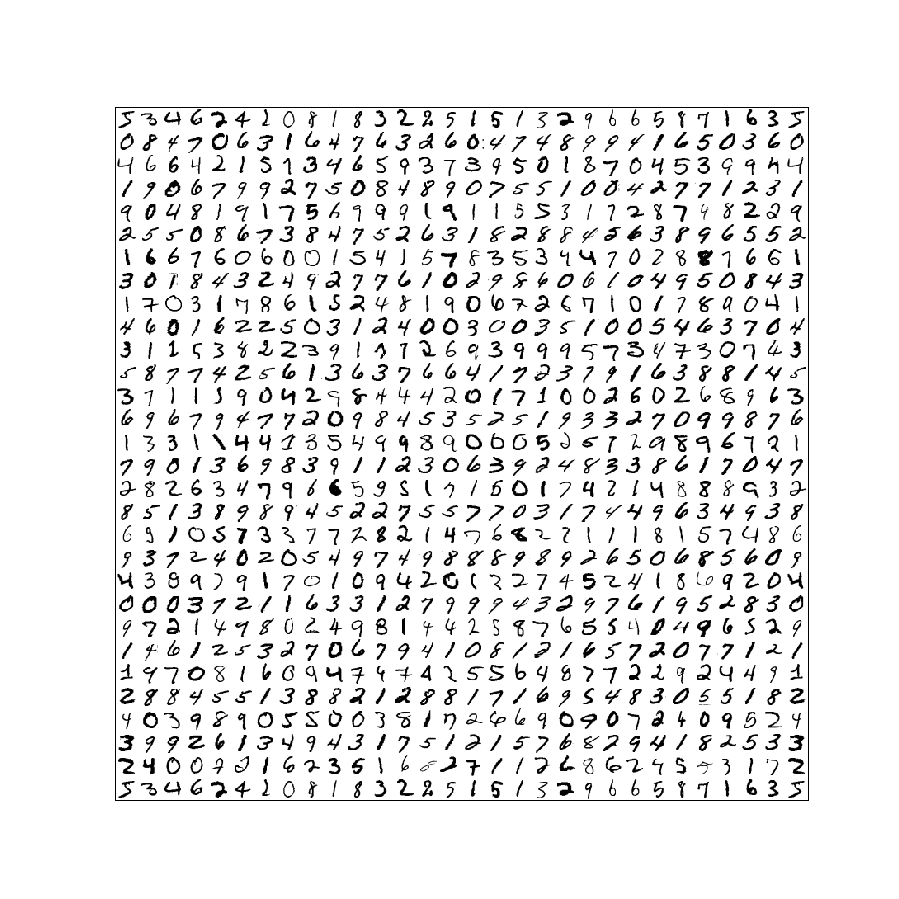

In [4]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))
plt.xticks([])
plt.yticks([])
plt.imshow(tapestry, cmap="gray_r")

In [5]:
x_o = 420
y_o = 420

sl = 28

x = x_o
y = y_o

v_x = 0
v_y = 0

v_max = 3

a_x = np.random.uniform(-1, 1)
a_y = np.random.uniform(-1, 1)

img_count = 10_000
imgs = []

del_t = 1

for i in range(img_count):
    if i % 20 == 0:
        a_x = np.random.uniform(-1, 1)
        a_y = np.random.uniform(-1, 1)
        
    x += v_x * del_t
    y += v_y * del_t
    v_x = np.clip(v_x + (a_x * del_t), -v_max, v_max)
    v_y = np.clip(v_y + (a_y * del_t), -v_max, v_max)
    
    x_f = int(x) % ((t_sl - 1) * m_sl)
    y_f = int(y) % ((t_sl - 1) * m_sl)
    
    imgs.append(tapestry[y_f: y_f + sl, x_f : x_f + sl])

<IPython.core.display.Javascript object>


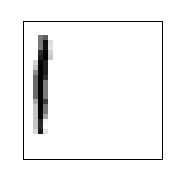

In [6]:
%matplotlib notebook
fig = plt.figure(figsize=(2, 2))

ims = []
for i in range(500):
    im = plt.imshow(imgs[i], cmap="gray_r", animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True,
                                repeat_delay=500)

plt.xticks([])
plt.yticks([])
plt.show()

In [7]:
img_array = np.array(imgs)
ts_data = img_array.reshape(-1, sl ** 2)
gp_data = cp.asarray(ts_data)

In [8]:
def draw_weights(w, Kx, Ky, s_len, fig):
    tapestry = np.zeros((s_len * Ky, s_len * Kx))
    
    w_i = 0
    for y in range(Ky):
        for x in range(Kx):
            tapestry[y * s_len: (y + 1) * s_len, x * s_len: (x + 1) * s_len] = w[w_i].reshape(s_len, s_len)
            w_i += 1
            
    plt.clf()        
    max_val = np.max(tapestry)
    im = plt.imshow(tapestry, cmap="Greys", vmax=max_val)
    fig.colorbar(im, ticks=[0, max_val])
    plt.axis("off")
    fig.canvas.draw()

In [9]:
def gen_lat_ex(Kx, Ky, ex, coeff):

    lat_ex = []

    for y in range(Ky):
        for x in range(Kx):
            curr_ex = np.zeros((Ky, Kx))
            curr_ex[max(0, y - ex): min(Ky, y + ex + 1), max(0, x - ex): min(Kx, x + ex + 1)] = 1

            if y - ex < 0:
                curr_ex[y - ex:, max(0, x - ex): min(Kx, x + ex + 1)] = 1
            if y + ex + 1 > Ky:
                curr_ex[:y + ex + 1 - Ky, max(0, x - ex): min(Kx, x + ex + 1)] = 1

            if x - ex < 0:
                curr_ex[max(0, y - ex): min(Ky, y + ex + 1), x - ex:] = 1
            if x + ex + 1 > Kx:
                curr_ex[max(0, y - ex): min(Ky, y + ex + 1), :x + ex + 1 - Kx] = 1

            if y - ex < 0 and x - ex < 0:
                curr_ex[y - ex:, x - ex:] = 1

            if x + ex + 1 > Kx and y + ex + 1 > Ky:
                curr_ex[:y + ex + 1 - Ky, :x + ex + 1 - Kx] = 1

            if y - ex < 0 and x + ex + 1 > Kx:
                curr_ex[y - ex:, :x + ex + 1 - Kx] = 1


            if x - ex < 0 and y + ex + 1 > Ky:
                curr_ex[:y + ex + 1 - Ky, x - ex:] = 1

            lat_ex.append(curr_ex.reshape(-1))

    lat_ex = cp.array(lat_ex)
    np.fill_diagonal(lat_ex, 0)

    lat_ex = (lat_ex / cp.linalg.norm(lat_ex, axis=1).reshape(-1, 1)) * coeff
    np.fill_diagonal(lat_ex, 1)
    
    return lat_ex

In [13]:
def wta_classification(wN, m_len, gp_ftr, sw, s_lat_ex, sN, iw, ww, gp_fte, y_te, y_tr):
    
    wins = cp.zeros((wN, 10))
    
    for i in tqdm(range(m_len)):

        v = gp_ftr[i].reshape(-1, 1)
                # Handle sparse layer
        p = sw @ v
        c = s_lat_ex @ p # Lat ex
        winners = cp.argsort(c, axis=0)[-n_w:]
        mask = cp.zeros((sN, 1))
        mask[winners] = 1
        so_uw = mask * p

        so = so_uw / cp.sum(sw, axis=1).reshape(-1, 1)

        # Handle invariant layer
        io = iw @ so
            
        # Handle MWTA layer
        p = ww @ io
        winner = cp.argmax(p)
        mask = cp.zeros((wN, 1))
        mask[winner] = 1
        wo = mask * p

        wta_wnr = cp.argmax(wo)
#         print(wta_wnr, y_tr[i], wins[int(wta_wnr), int(y_tr[i])])
        
        wins[int(wta_wnr), int(y_tr[i])] += 1
        
    cls = cp.argmax(wins, axis=1)
    
    num_correct = 0
    num_tests = gp_fte.shape[0]
    
    for i in tqdm(range(num_tests)):
            
        v = gp_fte[i].reshape(-1, 1)
        
        # Handle sparse layer
        p = sw @ v
        c = s_lat_ex @ p # Lat ex
        winners = cp.argsort(c, axis=0)[-n_w:]
        mask = cp.zeros((sN, 1))
        mask[winners] = 1
        so_uw = mask * p

        so = so_uw / cp.sum(sw, axis=1).reshape(-1, 1)

        # Handle invariant layer
        io = iw @ so
            
        # Handle MWTA layer
        p = ww @ io
        winner = cp.argmax(p)
        mask = cp.zeros((wN, 1))
        mask[winner] = 1
        wo = mask * p
        
        wta_wnr = cp.argmax(wo)
        
        if cls[wta_wnr] == y_te[i]:
            num_correct += 1
            
    print("Accuracy: ", 100 * num_correct / num_tests)

## Analysis Dialog

Well, let's hope this works.

<IPython.core.display.Javascript object>


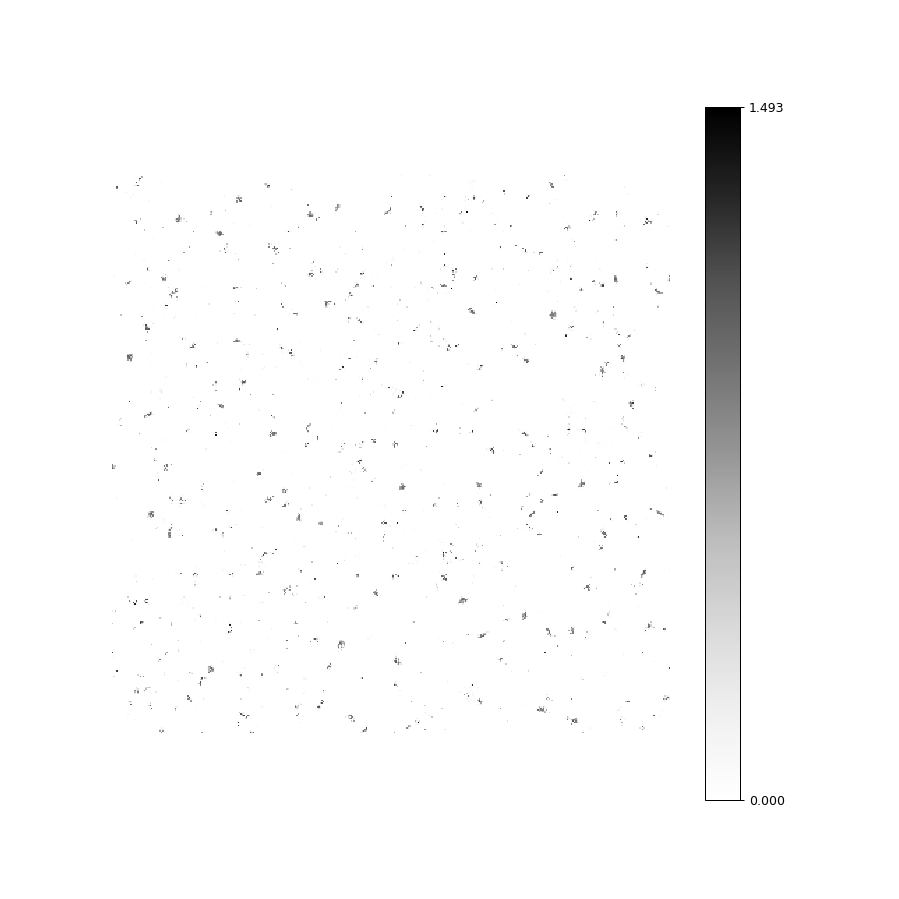

100%|██████████| 10000/10000 [00:14<00:00, 704.72it/s]


In [10]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 20
T_s = 10000
prec = 1e-10

# Sparse Layer
Kx = 40
Ky = 40
sN = Kx * Ky
m_len = sl ** 2
sex = 2
sex_coeff = 0.5

s_lat_ex = gen_lat_ex(Kx, Ky, sex, sex_coeff)

n_w = 5 #Number of winners


sw = cp.random.uniform(0, 0.2, (sN, m_len))
xi = 0.02

# Invariant Layer
Ix = 10
Iy = 10
iN = Ix * Iy

iw = cp.random.uniform(0, 0.1, (iN, sN))
alpha = 2 / 6
leta = 0.08
seta = 0.0008

i_norm = sN / iN

# WTA Layer
Wx = 10
Wy = 10
wN = Wx * Wy

ww = cp.random.uniform(0, 0.1, (wN, iN))
phi = 0.01


for ep in range(Nep):
    inputs = gp_data
    
    io = cp.zeros((iN, 1))
    
    for i in tqdm(range(T_s)):

        # Handle sparse layer
        v = inputs[i].reshape(-1, 1)
        p = sw @ v
        c = s_lat_ex @ p # Lat ex
        winners = cp.argsort(c, axis=0)[-n_w:]
        mask = cp.zeros((sN, 1))
        mask[winners] = 1
        so_uw = mask * p
        r = sw.T @ so_uw
        mod_r = cp.maximum(r, prec)
        e = v - r

        sw += sw * so_uw * (e / mod_r).T * xi

        so = so_uw / cp.sum(sw, axis=1).reshape(-1, 1)

        # Handle invariant layer
        io_pert = iw @ so
        
        io += (io_pert - io) * alpha

        # Train for reconstruction ability
        r = iw.T @ io
        mod_r = cp.maximum(r, prec)
        e = so - r
        zeta = np.where(so > 0, leta, seta)

        iw += iw * io * ((e * zeta) / mod_r).T
        
        if i % 2000 == 0:
            iw = i_norm * (iw / cp.sum(iw, axis=1).reshape(-1, 1))
            
        # Handle MWTA layer
        p = ww @ io
        winner = cp.argmax(p)
        mask = cp.zeros((wN, 1))
        mask[winner] = 1
        wo = mask * p
        r = ww.T @ wo
        mod_r = cp.maximum(r, prec)
        e = io - r
        
        ww += ww * wo * (e / mod_r).T * phi

    which_one = (ep // 2) % 3
    if which_one == 0:
        draw_weights(iw.get(), Ix, Iy, Kx, fig)
    elif which_one == 1:
        draw_weights(sw.get(), Kx, Ky, sl, fig)
    else:
        draw_weights(ww.get(), Wx, Wy, Ix, fig)

Hmm.  The final layer wasn't training fast at all.  I'm going to take a quick peak at what's actually being learned.

<IPython.core.display.Javascript object>


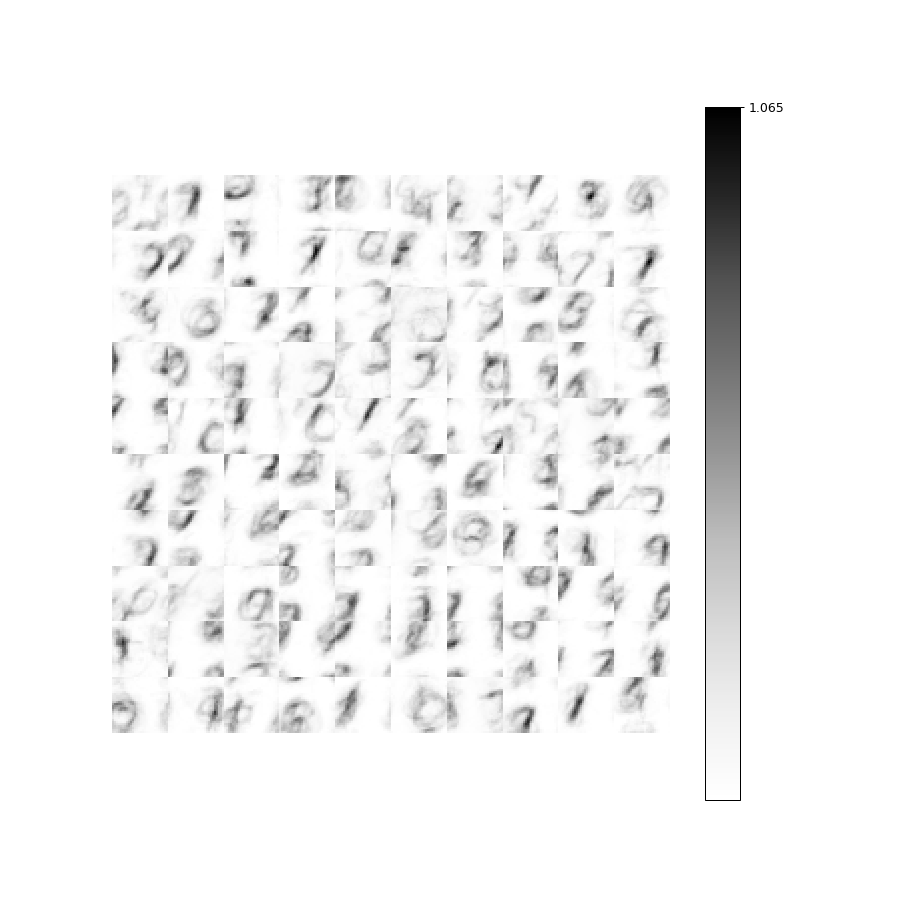

In [11]:
fig = plt.figure(figsize=(10, 10))

draw_weights((iw @ sw).get(), Ix, Iy, sl, fig)

Ok, I think that should be sufficient.  I'm going to stop training the first two layers to save time, and then I'm only going to plot the final layer to see what the snoots is happening.

<IPython.core.display.Javascript object>


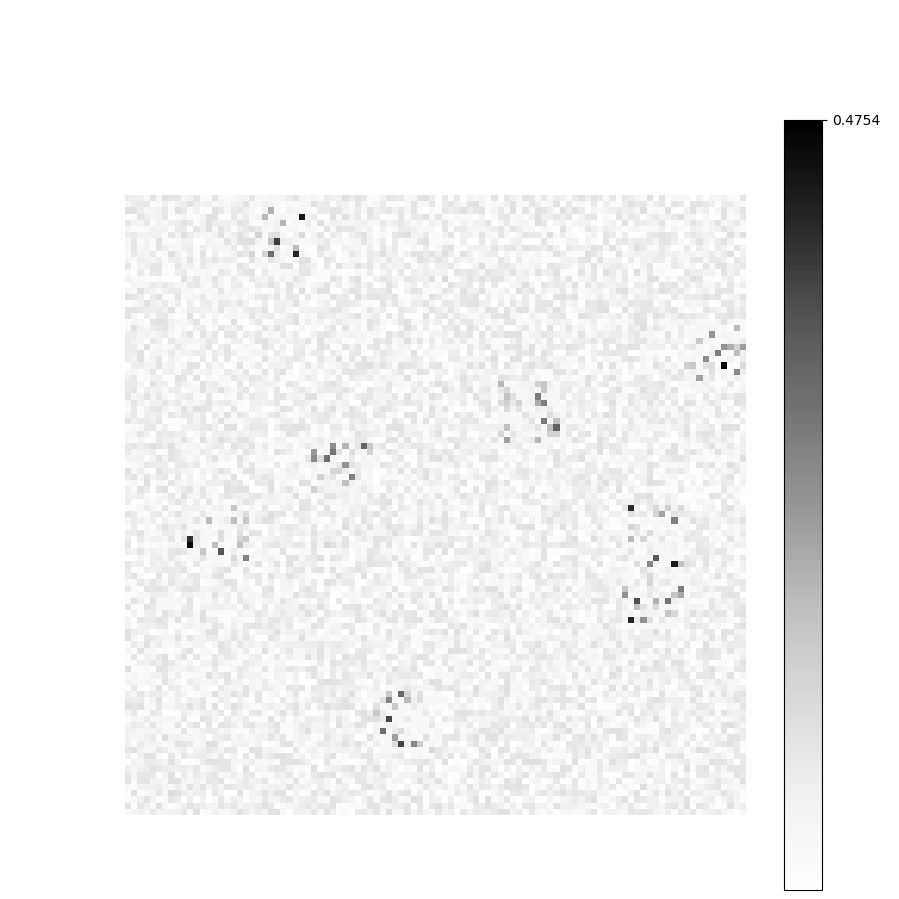

 21%|██        | 2101/10000 [00:02<00:10, 775.83it/s]


KeyboardInterrupt: 

In [12]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 20
T_s = 10000
prec = 1e-10

phi = 0.01


for ep in range(Nep):
    inputs = gp_data
    
    io = cp.zeros((iN, 1))
    
    for i in tqdm(range(T_s)):

        # Handle sparse layer
        v = inputs[i].reshape(-1, 1)
        p = sw @ v
        c = s_lat_ex @ p # Lat ex
        winners = cp.argsort(c, axis=0)[-n_w:]
        mask = cp.zeros((sN, 1))
        mask[winners] = 1
        so_uw = mask * p
        r = sw.T @ so_uw
        mod_r = cp.maximum(r, prec)
        e = v - r

#         sw += sw * so_uw * (e / mod_r).T * xi

        so = so_uw / cp.sum(sw, axis=1).reshape(-1, 1)

        # Handle invariant layer
        io_pert = iw @ so
        
        io += (io_pert - io) * alpha

        # Train for reconstruction ability
        r = iw.T @ io
        mod_r = cp.maximum(r, prec)
        e = so - r
        zeta = np.where(so > 0, leta, seta)

#         iw += iw * io * ((e * zeta) / mod_r).T
        
        if i % 2000 == 0:
            iw = i_norm * (iw / cp.sum(iw, axis=1).reshape(-1, 1))
            
        # Handle MWTA layer
        p = ww @ io
        winner = cp.argmax(p)
        mask = cp.zeros((wN, 1))
        mask[winner] = 1
        wo = mask * p
        r = ww.T @ wo
        mod_r = cp.maximum(r, prec)
        e = io - r
        
        ww += ww * wo * (e / mod_r).T * phi

    draw_weights(ww.get(), Wx, Wy, Ix, fig)

Ok, this isn't at all compelling.  Time to use constant initialization to try to get more actual prototypes.

<IPython.core.display.Javascript object>


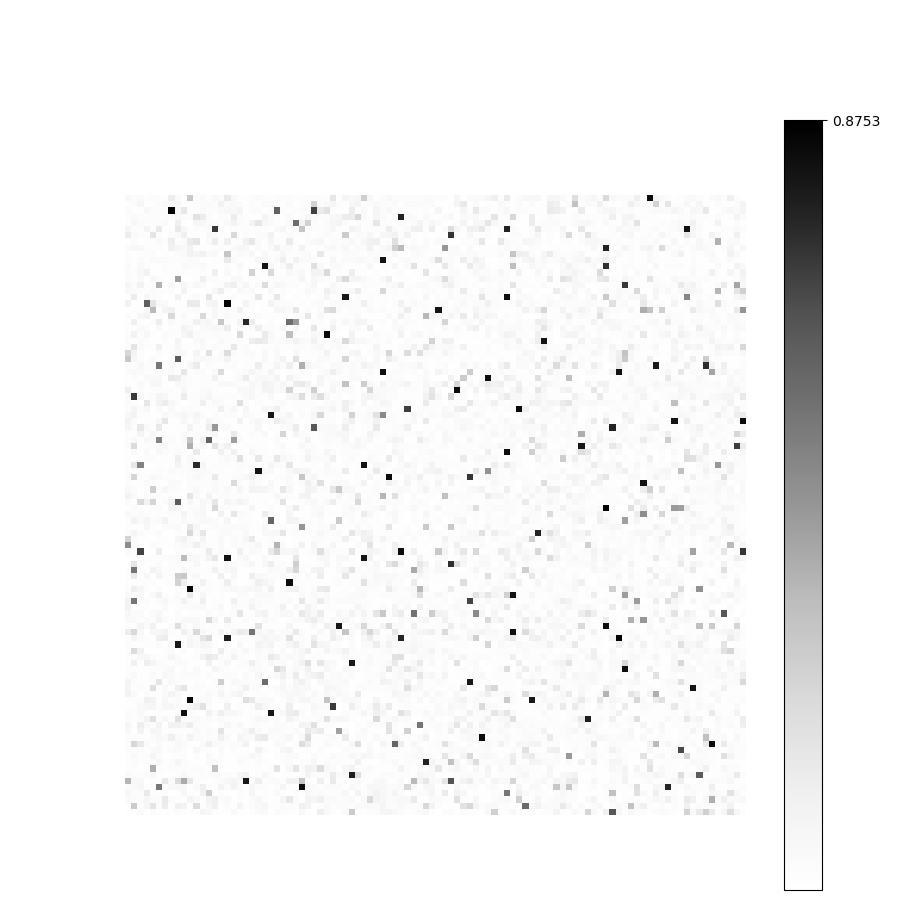

 11%|█         | 1112/10000 [00:01<00:13, 650.51it/s]


KeyboardInterrupt: 

In [13]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 20
T_s = 10000
prec = 1e-10

# WTA Layer
Wx = 10
Wy = 10
wN = Wx * Wy

ww = cp.random.uniform(0.4, 0.42, (wN, iN))
phi = 0.01


for ep in range(Nep):
    inputs = gp_data
    
    io = cp.zeros((iN, 1))
    
    for i in tqdm(range(T_s)):

        # Handle sparse layer
        v = inputs[i].reshape(-1, 1)
        p = sw @ v
        c = s_lat_ex @ p # Lat ex
        winners = cp.argsort(c, axis=0)[-n_w:]
        mask = cp.zeros((sN, 1))
        mask[winners] = 1
        so_uw = mask * p
        r = sw.T @ so_uw
        mod_r = cp.maximum(r, prec)
        e = v - r

        sw += sw * so_uw * (e / mod_r).T * xi

        so = so_uw / cp.sum(sw, axis=1).reshape(-1, 1)

        # Handle invariant layer
        io_pert = iw @ so
        
        io += (io_pert - io) * alpha

        # Train for reconstruction ability
        r = iw.T @ io
        mod_r = cp.maximum(r, prec)
        e = so - r
        zeta = np.where(so > 0, leta, seta)

        iw += iw * io * ((e * zeta) / mod_r).T
        
        if i % 2000 == 0:
            iw = i_norm * (iw / cp.sum(iw, axis=1).reshape(-1, 1))
            
        # Handle MWTA layer
        p = ww @ io
        winner = cp.argmax(p)
        mask = cp.zeros((wN, 1))
        mask[winner] = 1
        wo = mask * p
        r = ww.T @ wo
        mod_r = cp.maximum(r, prec)
        e = cp.clip(io - r, -1, 1)
        
        ww += ww * wo * (e / mod_r).T * phi

    draw_weights(ww.get(), Wx, Wy, Ix, fig)

Hmm, ok.  I honestly don't really know how to feel about that.  For the strongest prototypes, it's clear that the neurons are essentially latching on to one invariant neurons.  Yikes.

In [46]:
wta_classification(wN, m_len, gp_ftr, sw, s_lat_ex, sN, iw, ww, gp_fte, y_te, y_tr)

0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
0
5000
Accuracy:  43.61


Well fam, that's not great.  There are no two ways around it.  However, I think it may be in part because I simply used too few winners.  There are as many as 4 digits in view at a time.  I feel like I should probably use at least 10 winners.  

I'm going to try that now.

<IPython.core.display.Javascript object>


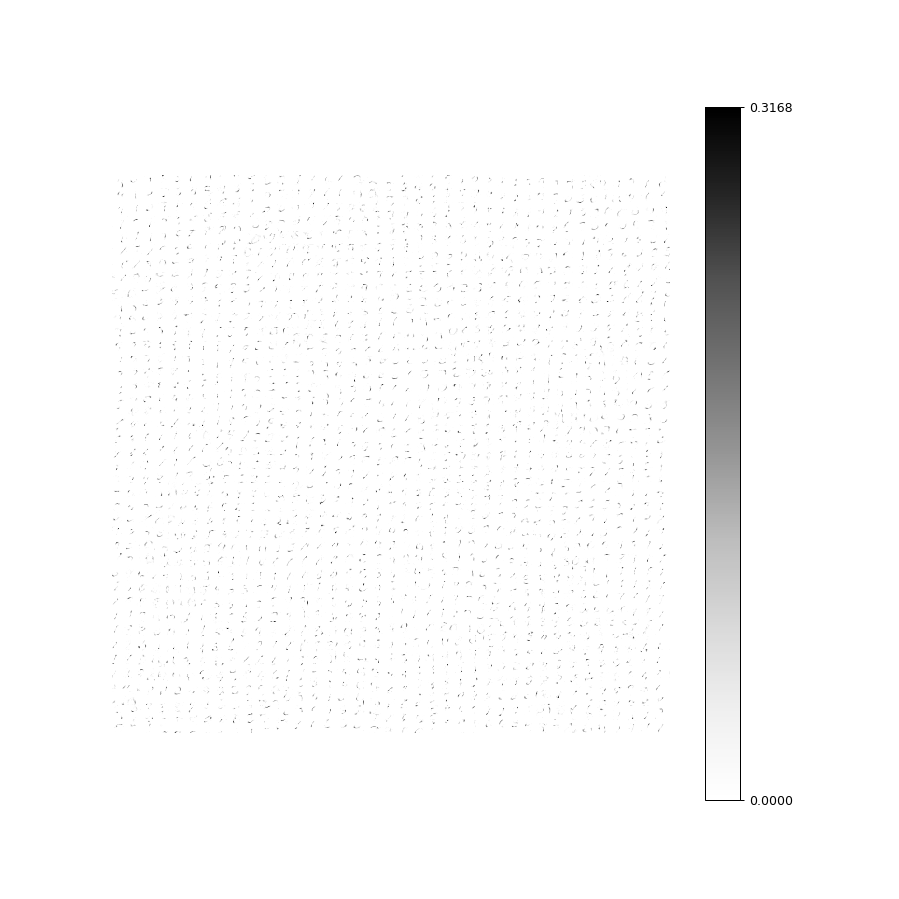

100%|██████████| 10000/10000 [00:15<00:00, 658.98it/s]


In [11]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 20
T_s = 10000
prec = 1e-10

# Sparse Layer
Kx = 40
Ky = 40
sN = Kx * Ky
m_len = sl ** 2
sex = 2
sex_coeff = 0.5

s_lat_ex = gen_lat_ex(Kx, Ky, sex, sex_coeff)

n_w = 15 #Number of winners


sw = cp.random.uniform(0.2, 0.21, (sN, m_len))
xi = 0.02

# Invariant Layer
Ix = 10
Iy = 10
iN = Ix * Iy

iw = cp.random.uniform(0, 0.1, (iN, sN))
alpha = 2 / 6
leta = 0.08
seta = 0.0008

i_norm = sN / iN

# WTA Layer
Wx = 10
Wy = 10
wN = Wx * Wy

ww = cp.random.uniform(0.3, 0.32, (wN, iN))
phi = 0.01


for ep in range(Nep):
    inputs = gp_data
    
    io = cp.zeros((iN, 1))
    
    for i in tqdm(range(T_s)):

        # Handle sparse layer
        v = inputs[i].reshape(-1, 1)
        p = sw @ v
        c = s_lat_ex @ p # Lat ex
        winners = cp.argsort(c, axis=0)[-n_w:]
        mask = cp.zeros((sN, 1))
        mask[winners] = 1
        so_uw = mask * p
        r = sw.T @ so_uw
        mod_r = cp.maximum(r, prec)
        e = v - r

        sw += sw * so_uw * (e / mod_r).T * xi

        so = so_uw / cp.sum(sw, axis=1).reshape(-1, 1)

        # Handle invariant layer
        io_pert = iw @ so
        
        io += (io_pert - io) * alpha

        # Train for reconstruction ability
        r = iw.T @ io
        mod_r = cp.maximum(r, prec)
        e = so - r
        zeta = np.where(so > 0, leta, seta)

        iw += iw * io * ((e * zeta) / mod_r).T
        
        if i % 2000 == 0:
            iw = i_norm * (iw / cp.sum(iw, axis=1).reshape(-1, 1))
            
        # Handle MWTA layer
        p = ww @ io
        winner = cp.argmax(p)
        mask = cp.zeros((wN, 1))
        mask[winner] = 1
        wo = mask * p
        r = ww.T @ wo
        mod_r = cp.maximum(r, prec)
        e = io - r
        
        ww += ww * wo * (e / mod_r).T * phi

    which_one = (ep // 2) % 3
    if which_one == 1:
        draw_weights(iw.get(), Ix, Iy, Kx, fig)
    elif which_one == 0:
        draw_weights(sw.get(), Kx, Ky, sl, fig)
    else:
        draw_weights(ww.get(), Wx, Wy, Ix, fig)

<IPython.core.display.Javascript object>


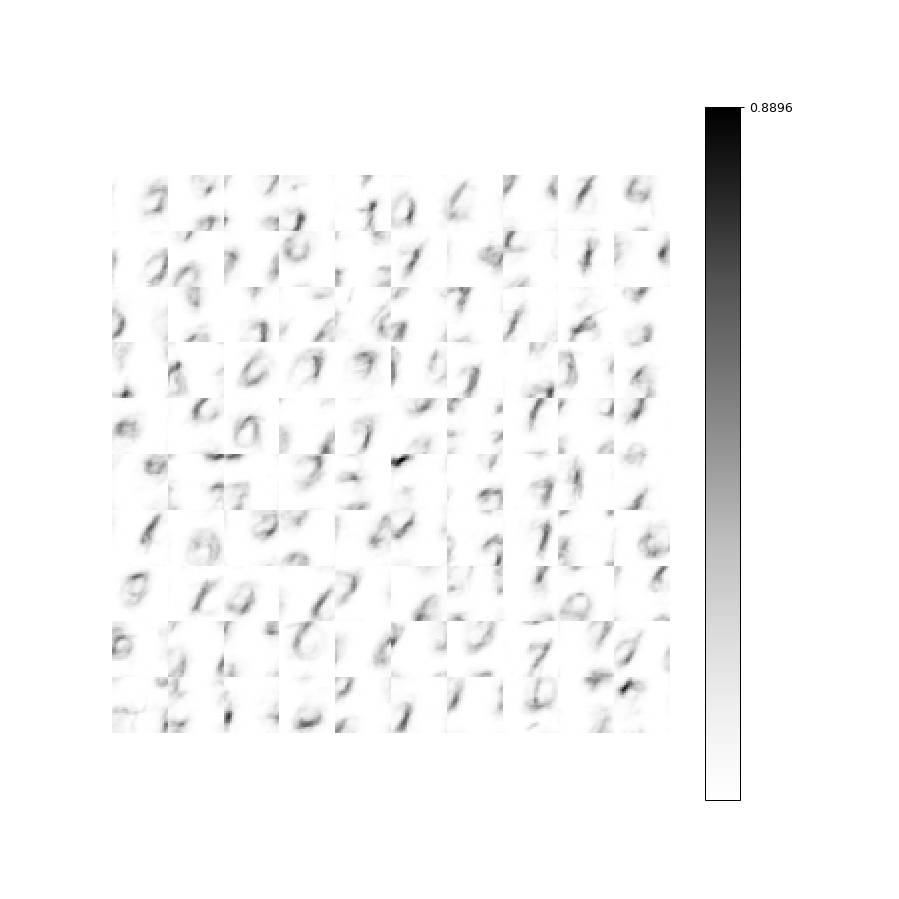

In [12]:
fig = plt.figure(figsize=(10, 10))

draw_weights((iw @ sw).get(), Ix, Iy, sl, fig)

In [16]:
wta_classification(wN, 60_000, gp_ftr, sw, s_lat_ex, sN, iw, ww, gp_fte, y_te, y_tr)

100%|██████████| 10000/10000 [00:09<00:00, 1107.86it/s]

Accuracy:  30.51


Beloved snoots.  The accuracy is somehow... worse?  I think I might just need more neurons in my invariant layer...

<IPython.core.display.Javascript object>


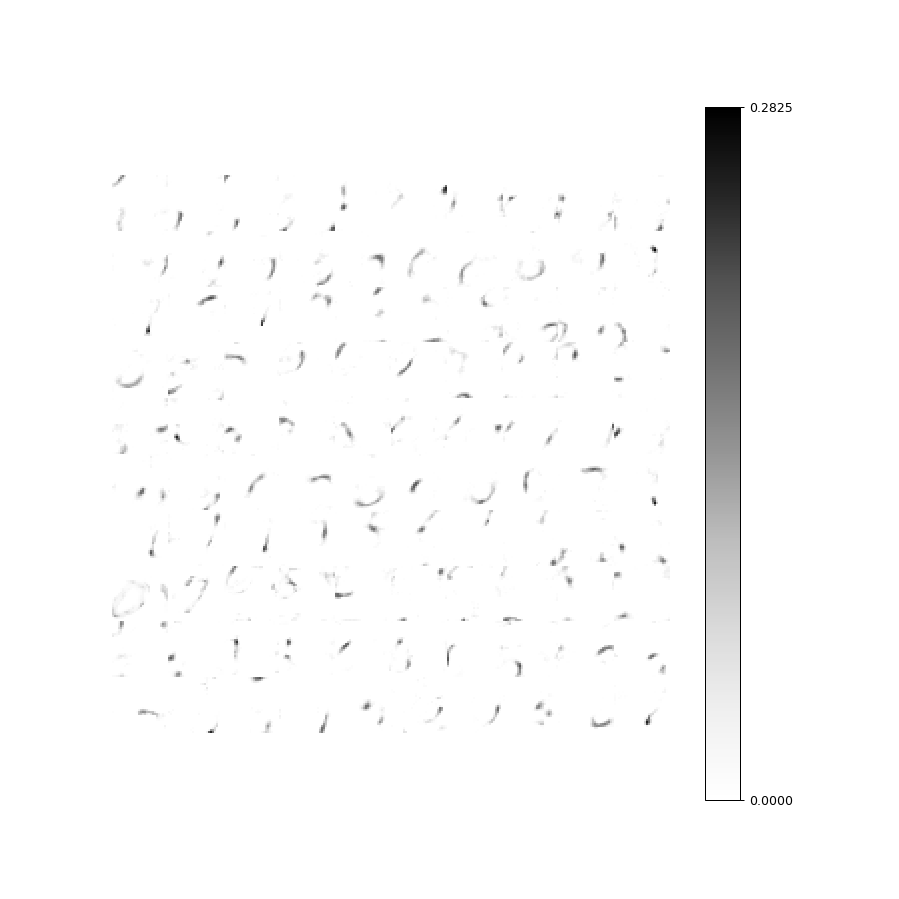

In [18]:
fig = plt.figure(figsize=(10, 10))

draw_weights(sw.get()[100:200], Ix, Iy, sl, fig)

I think those prototypes are a pretty good size, however.  Yeah, I guess maybe more var xi neurons... Ok, let's try it.

Also, you know what? I'm going to train the final wta layer on `io_pert` instead of `io`.  That seems like a good idea.

<IPython.core.display.Javascript object>


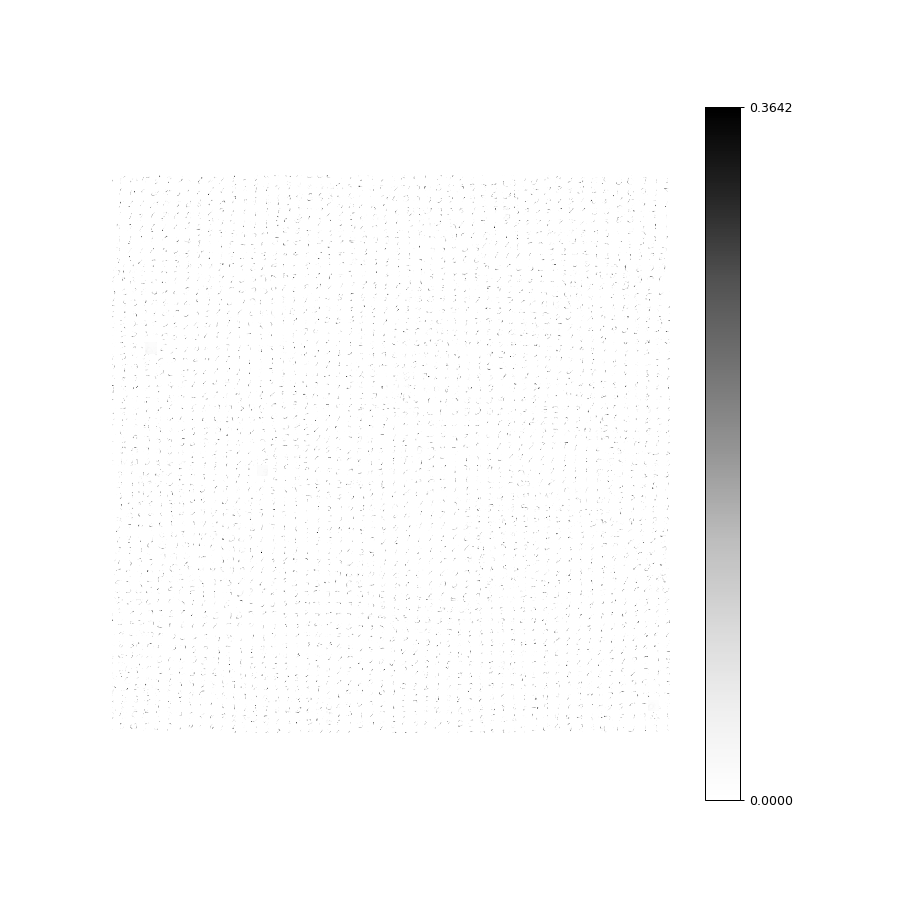

100%|██████████| 10000/10000 [00:16<00:00, 600.97it/s]


In [22]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 20
T_s = 10000
prec = 1e-10

# Sparse Layer
Kx = 50
Ky = 50
sN = Kx * Ky
m_len = sl ** 2
sex = 2
sex_coeff = 0.5

s_lat_ex = gen_lat_ex(Kx, Ky, sex, sex_coeff)

n_w = 15 #Number of winners


sw = cp.random.uniform(0.2, 0.21, (sN, m_len))
xi = 0.04

# Invariant Layer
Ix = 15
Iy = 15
iN = Ix * Iy

iw = cp.random.uniform(0, 0.1, (iN, sN))
alpha = 2 / 6
leta = 0.08
seta = 0.0008

i_norm = sN / iN

# WTA Layer
Wx = 10
Wy = 10
wN = Wx * Wy

ww = cp.random.uniform(0.3, 0.32, (wN, iN))
phi = 0.02


for ep in range(Nep):
    inputs = gp_data
    
    io = cp.zeros((iN, 1))
    
    for i in tqdm(range(T_s)):

        # Handle sparse layer
        v = inputs[i].reshape(-1, 1)
        p = sw @ v
        c = s_lat_ex @ p # Lat ex
        winners = cp.argsort(c, axis=0)[-n_w:]
        mask = cp.zeros((sN, 1))
        mask[winners] = 1
        so_uw = mask * p
        r = sw.T @ so_uw
        mod_r = cp.maximum(r, prec)
        e = cp.clip(v - r, -4, 4)

        sw += sw * so_uw * (e / mod_r).T * xi

        so = so_uw / cp.sum(sw, axis=1).reshape(-1, 1)

        # Handle invariant layer
        io_pert = iw @ so
        
        io += (io_pert - io) * alpha

        # Train for reconstruction ability
        r = iw.T @ io
        mod_r = cp.maximum(r, prec)
        e = so - r
        zeta = np.where(so > 0, leta, seta)

        iw += iw * io * ((e * zeta) / mod_r).T
        
        if i % 2000 == 0:
            iw = i_norm * (iw / cp.sum(iw, axis=1).reshape(-1, 1))
            
        # Handle MWTA layer
        p = ww @ io
        winner = cp.argmax(p)
        mask = cp.zeros((wN, 1))
        mask[winner] = 1
        wo = mask * p
        r = ww.T @ wo
        mod_r = cp.maximum(r, prec)
        e = io - r
        
        ww += ww * wo * (e / mod_r).T * phi

    which_one = (ep // 2) % 3
    if which_one == 1:
        draw_weights(iw.get(), Ix, Iy, Kx, fig)
    elif which_one == 0:
        draw_weights(sw.get(), Kx, Ky, sl, fig)
    else:
        draw_weights(ww.get(), Wx, Wy, Ix, fig)

I forgot to train on `io_pert`! FUUUUUUCCCCCCKKKKKK MEEEEEEEEE.  AHHHHH

Whatever.  That's rough.  The annoying part is that this is starting to take the network awhile to train.

<IPython.core.display.Javascript object>


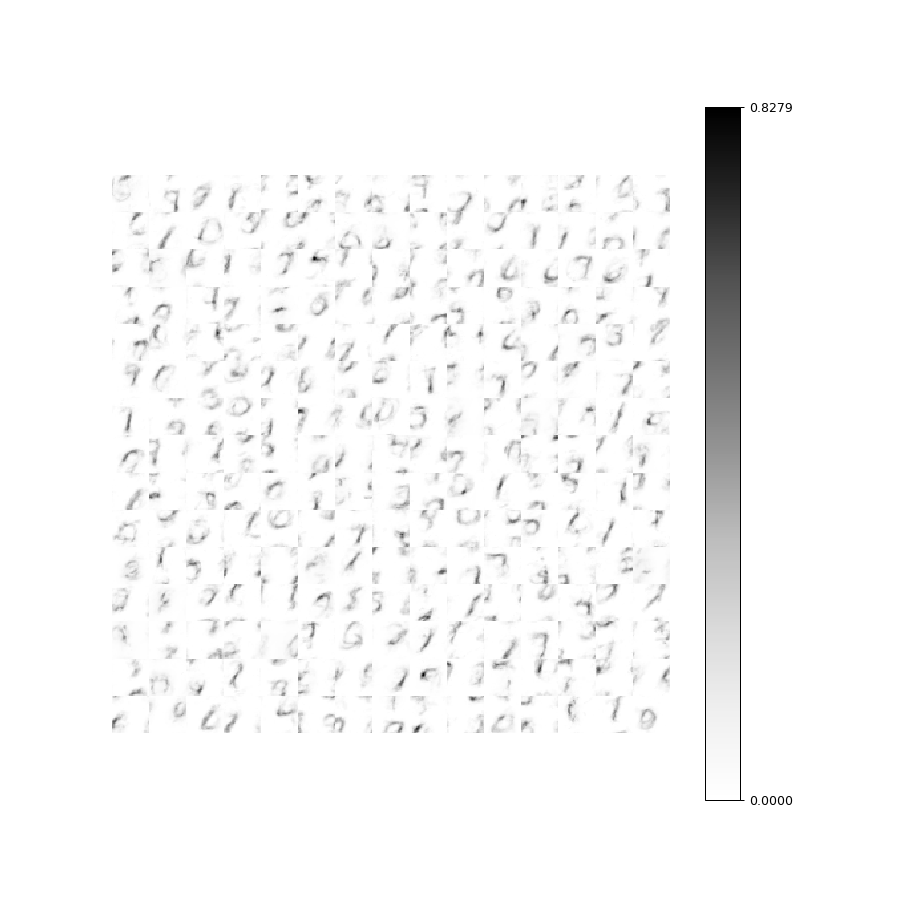

In [23]:
fig = plt.figure(figsize=(10, 10))

draw_weights((iw @ sw).get(), Ix, Iy, sl, fig)

In [24]:
wta_classification(wN, 60_000, gp_ftr, sw, s_lat_ex, sN, iw, ww, gp_fte, y_te, y_tr)

100%|██████████| 10000/10000 [00:10<00:00, 966.87it/s]

Accuracy:  37.28


Ok, well that sucks.  But I mean you gotta go somewhere from there, right?  

Here's an idea.  What if you train the first layer and the invariant layer on the tapestry, but then you train the wta layer only on single digits.  That's an interesting idea.  But first, I'm actually going to train this bad boi on `io_pert`.  Erhmbleh.

Also I'm going to use the previously trained layers to hopefully get better prototypes in the final layer.

<IPython.core.display.Javascript object>


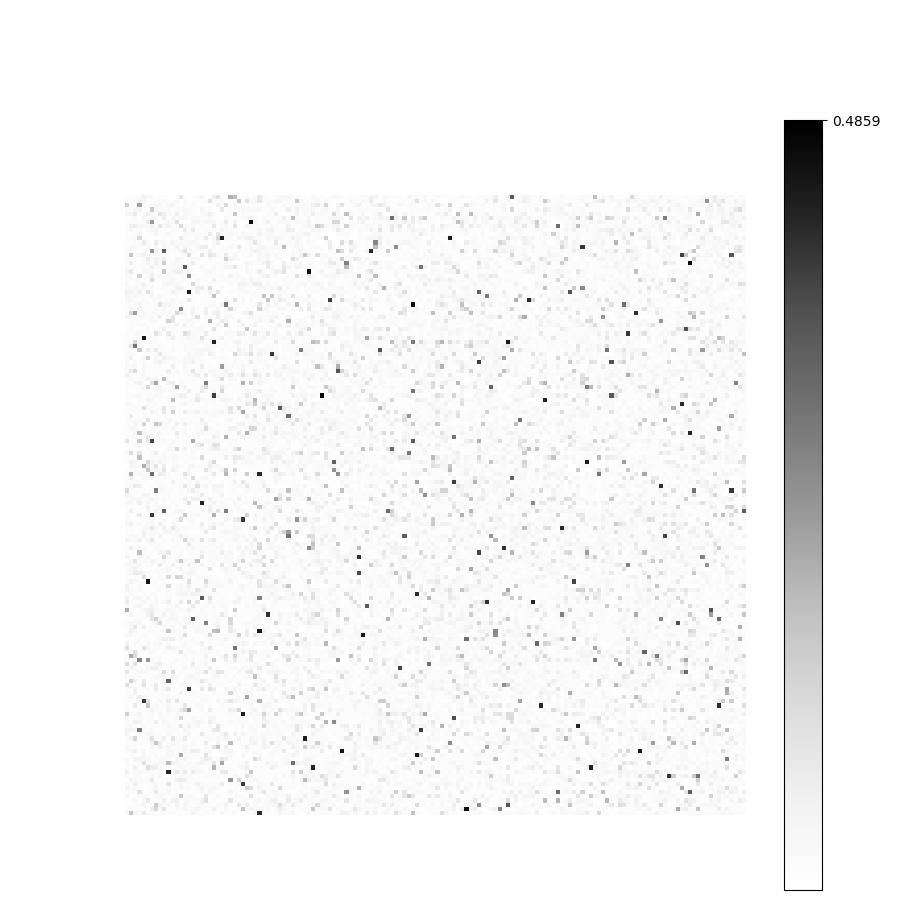

 34%|███▍      | 3382/10000 [00:05<00:11, 588.02it/s]


KeyboardInterrupt: 

In [25]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 20
T_s = 10000
prec = 1e-10

# WTA Layer
Wx = 10
Wy = 10
wN = Wx * Wy

ww = cp.random.uniform(0.3, 0.32, (wN, iN))
phi = 0.02


for ep in range(Nep):
    inputs = gp_data
    
    io = cp.zeros((iN, 1))
    
    for i in tqdm(range(T_s)):

        # Handle sparse layer
        v = inputs[i].reshape(-1, 1)
        p = sw @ v
        c = s_lat_ex @ p # Lat ex
        winners = cp.argsort(c, axis=0)[-n_w:]
        mask = cp.zeros((sN, 1))
        mask[winners] = 1
        so_uw = mask * p
        r = sw.T @ so_uw
        mod_r = cp.maximum(r, prec)
        e = cp.clip(v - r, -4, 4)

        sw += sw * so_uw * (e / mod_r).T * xi

        so = so_uw / cp.sum(sw, axis=1).reshape(-1, 1)

        # Handle invariant layer
        io_pert = iw @ so
        
        io += (io_pert - io) * alpha

        # Train for reconstruction ability
        r = iw.T @ io
        mod_r = cp.maximum(r, prec)
        e = so - r
        zeta = np.where(so > 0, leta, seta)

        iw += iw * io * ((e * zeta) / mod_r).T
        
        if i % 2000 == 0:
            iw = i_norm * (iw / cp.sum(iw, axis=1).reshape(-1, 1))
            
        # Handle MWTA layer
        p = ww @ io_pert
        winner = cp.argmax(p)
        mask = cp.zeros((wN, 1))
        mask[winner] = 1
        wo = mask * p
        r = ww.T @ wo
        mod_r = cp.maximum(r, prec)
        e = io - r
        
        ww += ww * wo * (e / mod_r).T * phi

    which_one = (ep // 2) % 4
    if which_one == 3:
        draw_weights(iw.get(), Ix, Iy, Kx, fig)
    elif which_one == 4:
        draw_weights(sw.get(), Kx, Ky, sl, fig)
    else:
        draw_weights(ww.get(), Wx, Wy, Ix, fig)

Ok, it's not learning much anymore.

In [26]:
wta_classification(wN, 60_000, gp_ftr, sw, s_lat_ex, sN, iw, ww, gp_fte, y_te, y_tr)

100%|██████████| 10000/10000 [00:10<00:00, 996.33it/s]

Accuracy:  36.57


Ok, here's something.  Most of what the network is seeing are intermediate stages between different digits.  Imma train the network again, but on actual digits.  And by train the network again, I mean fix the first two layers, and just pass digits in front to train the final layer.

<IPython.core.display.Javascript object>


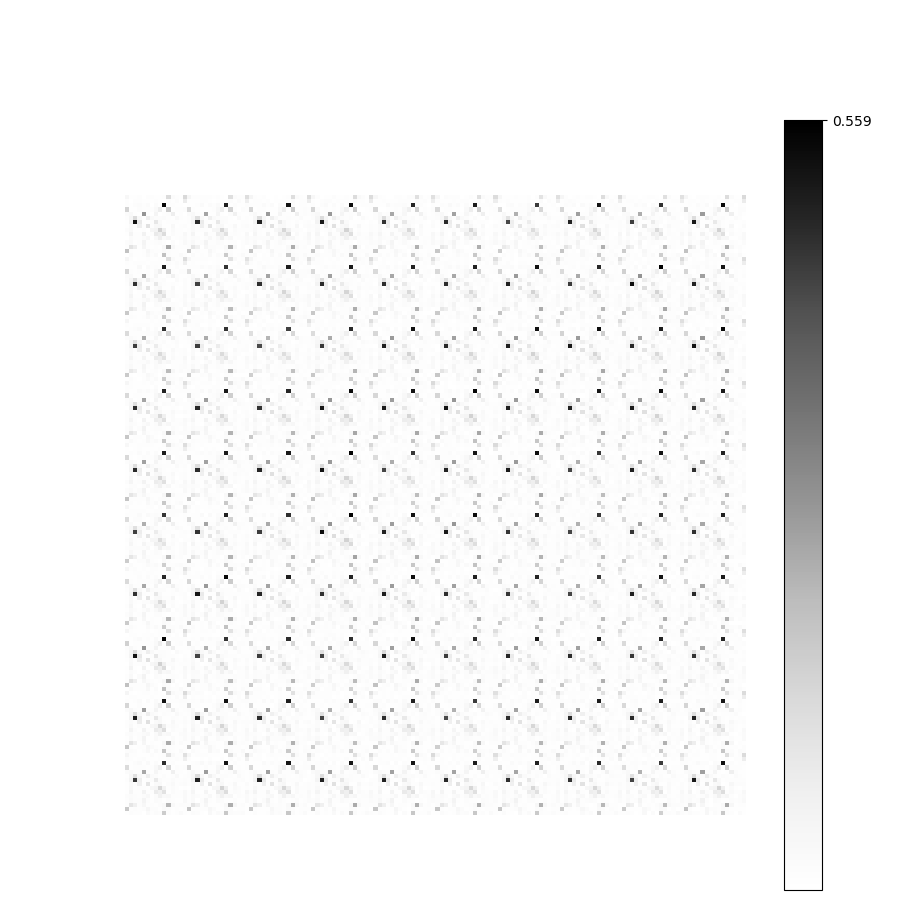

  5%|▌         | 548/10000 [00:00<00:10, 882.49it/s]


KeyboardInterrupt: 

In [40]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 10
T_s = 10_000
m_len = 60_000
prec = 1e-10

# WTA Layer
Wx = 10
Wy = 10
wN = Wx * Wy

ww = cp.random.uniform(0.2, 0.22, (wN, iN))
phi = 0.001


for ep in range(Nep):
    inputs = gp_ftr[cp.random.permutation(m_len)]
    
    for i in tqdm(range(T_s)):

        # Handle sparse layer
        v = inputs[i].reshape(-1, 1)
        p = sw @ v
        c = s_lat_ex @ p # Lat ex
        winners = cp.argsort(c, axis=0)[-n_w:]
        mask = cp.zeros((sN, 1))
        mask[winners] = 1
        so_uw = mask * p

        so = so_uw / cp.sum(sw, axis=1).reshape(-1, 1)

        # Handle invariant layer
        io_pert = iw @ so
            
        # Handle MWTA layer
        p = ww @ io_pert
        winner = cp.argmax(p)
        mask = cp.zeros((wN, 1))
        mask[winner] = 1
        wo = mask * p
        r = ww.T @ wo
        mod_r = cp.maximum(r, prec)
        e = cp.clip(io - r, -1, 1)
        
        ww += ww * wo * (e / mod_r).T * phi

    draw_weights(ww.get(), Wx, Wy, Ix, fig)

Not a fan!  Not a fan at all.  What the actual flippety flip is going on.  

<IPython.core.display.Javascript object>


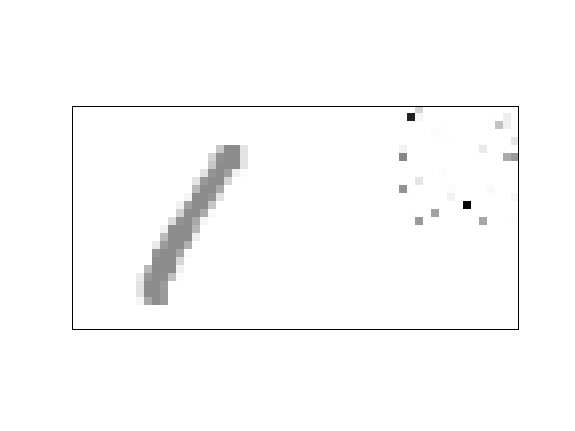

In [38]:
img_i = 3

v = gp_ftr[img_i].reshape(-1, 1)
p = sw @ v
c = s_lat_ex @ p # Lat ex
winners = cp.argsort(c, axis=0)[-n_w:]
mask = cp.zeros((sN, 1))
mask[winners] = 1
so_uw = mask * p

so = so_uw / cp.sum(sw, axis=1).reshape(-1, 1)

# Handle invariant layer
io_pert = iw @ so

tap = np.zeros((28, 28 * 2))

tap[:, :28] = v.get().reshape(28, 28)
tap[:15, -15:] = io_pert.get().reshape(15, 15)

plt.figure()

plt.xticks([])
plt.yticks([])

plt.imshow(tap, cmap='gray_r')
plt.show()

Yeah, I'm not sure what's going on, but I think I'm going to close this bad boi down.  This amount of things failing is annoying to deal with.

## Conclusions

Well, true to the scientific process, everything broke.  I don't know why, and I don't know how, but it really, really broke.  Fan-fucking-tastic.  

Ok, here's what I think I know.  The network was almost always focusing on some intermediate state between several different digits.  With that said, it's probably the case that most of the prototypes in the final layer were focusing on frames that were in between different states, and therefore didn't have a great classification accuracy.  I guess I could train the network with more neurons.  Maybe that's a thing to do for tomorrow.

## Next steps

Train a network whose first two layers are pre-trained with more neurons in the last layer.  And work on the idea of electricity minimization you came up with today.